# Probabilistic Programming and Bayesian Methods for Hackers

http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

## Chap 3: Opening the black box of MCMC

### In a nutshell
P/s: Well, I think through this chapter, MCMC still remains a black box to me LOL :). Solid understanding requires further reading.

This chapter assumes a prior understanding of MCMC: *what it is, why it is important*. Rather, the author primarily mentioned how MCMC works under the hood and some of its practical problems.

#### General
- Basically, the term MCMC (Markov Chain Monte Carlo) could be cracked down into 2 parts:
    - **Monte Carlo**: *a simulation technique, aiming at providing approximate solutions through sampling*. This method is pretty useful especially when it comes to the case that the distribution is too complicated that computing analytical expectation is intractable. Posterior probabilities are such typical examples.
    - **Markov Chain**: *a sampling method*.
- **Burn-in period**: refers to the beginning period when the algorithm moves from the starting point to a position which acceptably represents the distribution (ie. relatively high probability).
- A good **starting values** could help shorten the *burn-in period* and boost the convergence. Several ways to pick a smart initial value:
    - Using **MAP** (maximum a posterior).
    - Using frequentist estimates. For example, choose `mean(observed_data)` as $\mu_0$

#### Diagnosing
- The late posterior samples should not have high **autocorrelation**. Intuition: *higher autocorrelation = more meandering graph = more unstable results*.
- One approach to mitigate high-autocorrelation issues is **thining**. However, it requires more steps of running.
- Carefully choose the priors. *Often, lack of covergence or evidence of samples crowding to boundaries implies something is wrong with the chosen priors*.

### Favorite stuff
The Folk theorem of statistical computing.
> *If you are having computational problems, probably your model is wrong*

### Examples

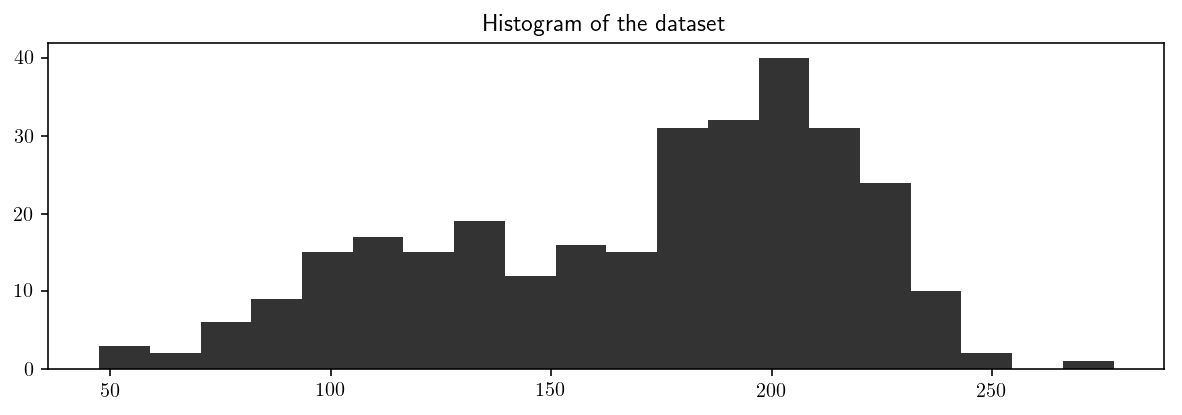

[ 115.85679142  152.26153716  178.87449059  162.93500815  107.02820697
  105.19141146  118.38288501  125.3769803   102.88054011  206.71326136] ...


In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
%config InlineBackend.figure_format = 'retina'

data = np.loadtxt('data/mixture_data.csv', delimiter=',')

figsize(10, 3)
plt.hist(data, bins=20, color='k', histtype='stepfilled', alpha=0.8)
plt.title('Histogram of the dataset')
plt.ylim([0, None])
plt.show()
print(data[:10], '...')

In [2]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    assignment = pm.Categorical(name='assignment', p=p, shape=data.shape[0],
        testval=np.random.randint(0, 2, data.shape[0]))
print('prior assignment, with p = %.2f: %s' % (p1.tag.test_value, assignment.tag.test_value[:10]))
    

prior assignment, with p = 0.50: [1 0 1 1 1 0 1 1 0 0]


In [3]:
with model:
    sds = pm.Uniform('sds', 0, 100, shape=2)
    centers = pm.Normal('centers', mu=np.array([120, 190]), sd=np.array([10, 10]), shape=2)
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    obsevations = pm.Normal('obs', mu=center_i, sd=sd_i, observed=data)

print('Random assignments:', assignment.tag.test_value[:4], '...')
print('Assigned centers:', center_i.tag.test_value[:4], '...')
print('Assigned standard deviation:', sd_i.tag.test_value[:4], '...')

Random assignments: [1 0 1 1] ...
Assigned centers: [ 190.  120.  190.  190.] ...
Assigned standard deviation: [ 50.  50.  50.  50.] ...


In [4]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.CategoricalGibbsMetropolis(vars=[assignment])
    trace = pm.sample(5000, step=[step1, step2])

100%|██████████| 5500/5500 [02:54<00:00, 32.25it/s]


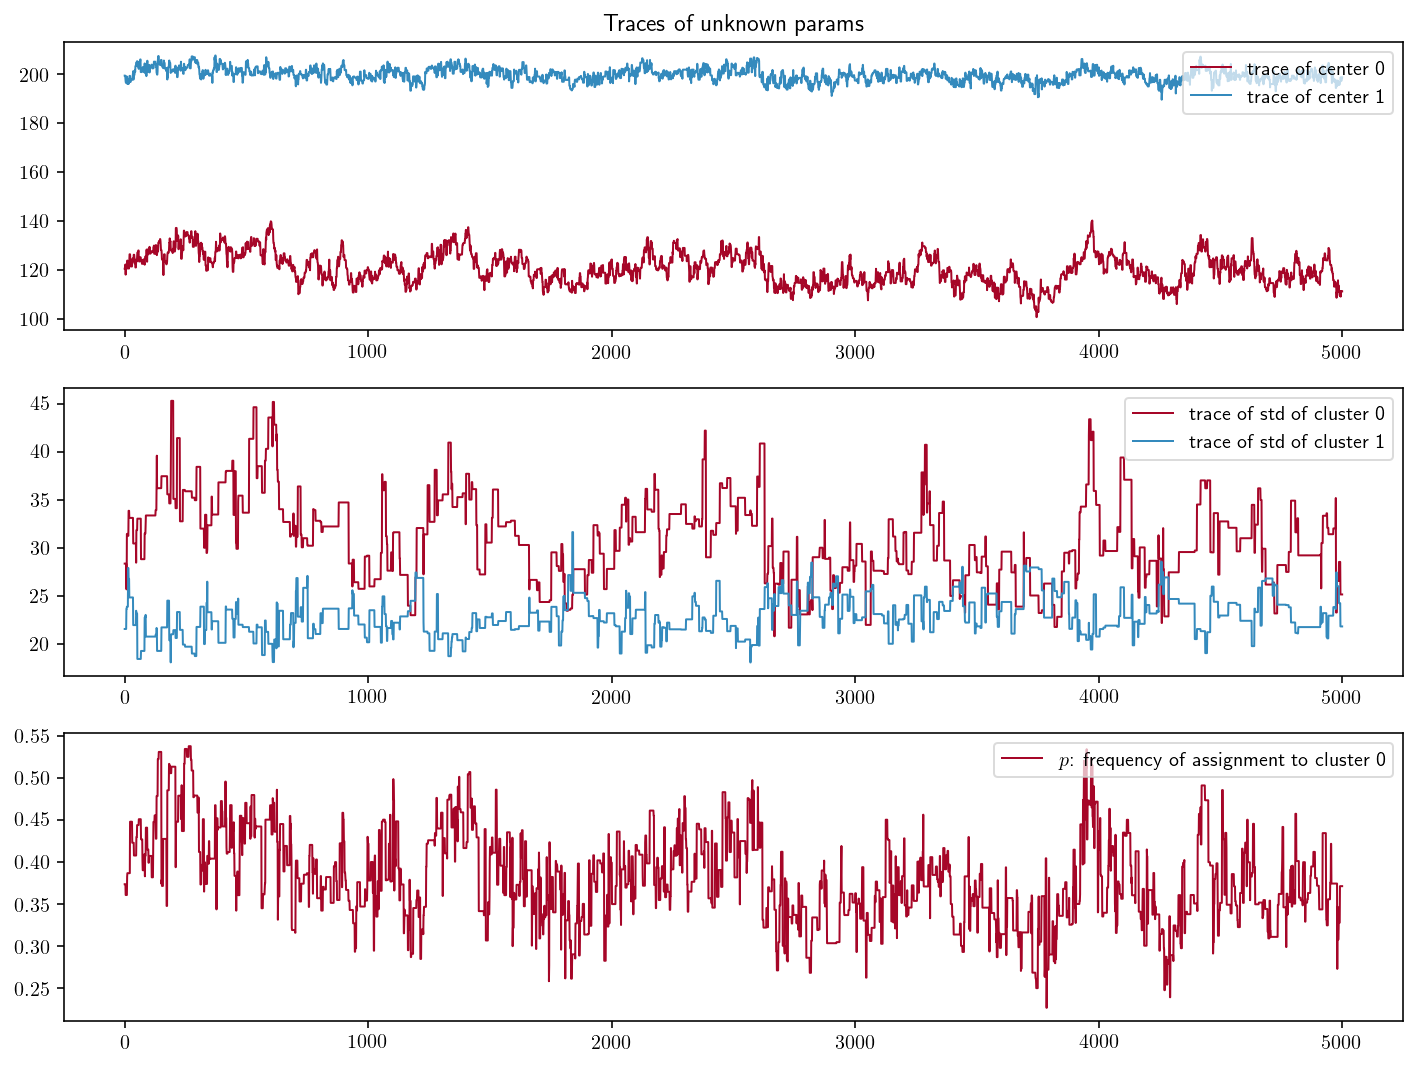

In [5]:
figsize(12, 9)

lw = 1
center_trace = trace['centers']
colors = ['#348ABD', '#A60628'] if center_trace[-1, 0] > center_trace[-1, 1] else ['#A60628', '#348ABD']

plt.subplot(311)
plt.plot(center_trace[:, 0], label='trace of center 0', c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label='trace of center 1', c=colors[1], lw=lw)
plt.title('Traces of unknown params')
leg = plt.legend(loc='upper right')
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace['sds']
plt.plot(std_trace[:, 0], label='trace of std of cluster 0', c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label='trace of std of cluster 1', c=colors[1], lw=lw)
leg = plt.legend(loc='upper right')
leg.get_frame().set_alpha(0.7)

plt.subplot(313)
p_trace = trace['p']
plt.plot(p_trace, label='$p$: frequency of assignment to cluster 0', c=colors[0], lw=lw)
leg = plt.legend(loc='upper right')
leg.get_frame().set_alpha(0.7)

plt.show()

#### Cluster investigation

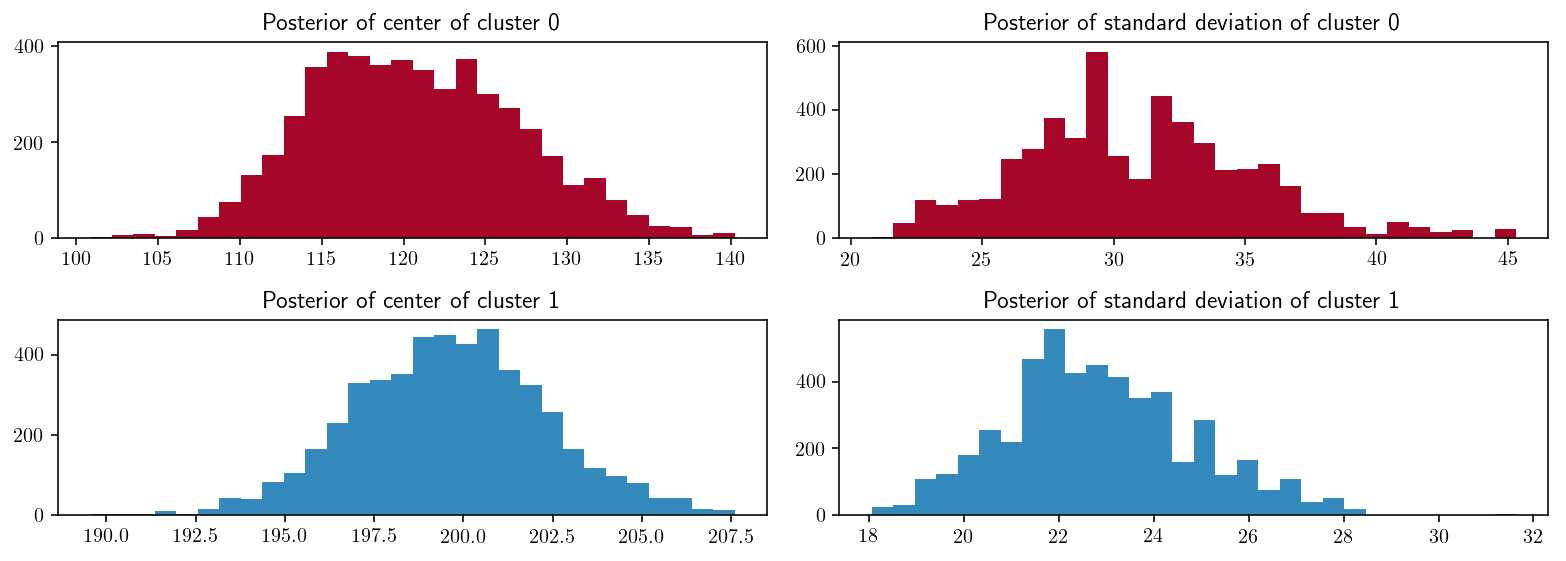

In [6]:
figsize(11, 4)
std_trace = trace['sds'][-10000:]
prev_std_trace = trace['sds'][:10000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title('Posterior of center of cluster %d' % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30, histtype='stepfilled')

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title('Posterior of standard deviation of cluster %d' % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30, histtype='stepfilled')
    # plt.autoscale(tight=True)

plt.tight_layout()
plt.show()

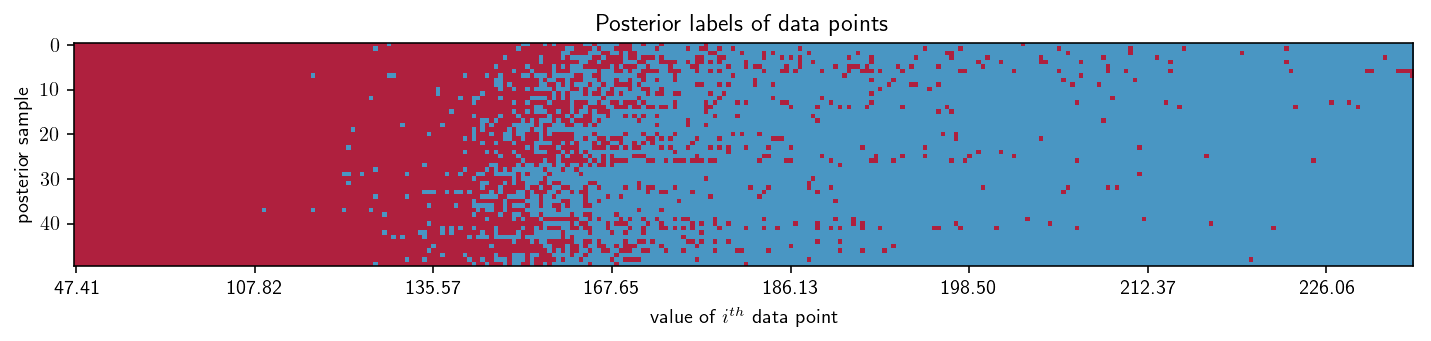

In [7]:
import matplotlib as mpl

figsize(12, 4)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(trace['assignment'][::100, np.argsort(data)], cmap=plt.cmap, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40), ['%.2f' % s for s in np.sort(data)[::40]])
plt.ylabel('posterior sample')
plt.xlabel('value of $i^{th}$ data point')
plt.title('Posterior labels of data points')
plt.show()


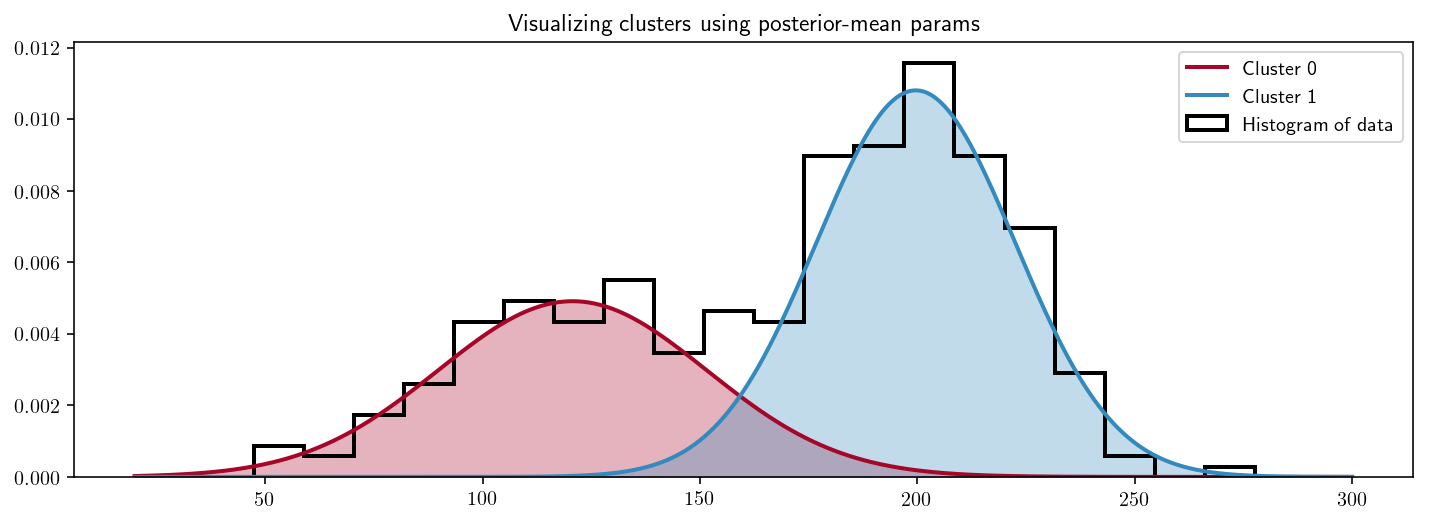

In [8]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace['p'].mean()
y0 = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0], scale=posterior_std_means[0])
y1 = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1], scale=posterior_std_means[1])

plt.hist(data, bins=20, histtype='step', normed=True, color='k', lw=2, label='Histogram of data')
plt.plot(x, y0, label='Cluster 0', c=colors[0], lw=2)
plt.plot(x, y1, label='Cluster 1', c=colors[1], lw=2)
plt.fill_between(x, y0, color=colors[0], alpha=.3)
plt.fill_between(x, y1, color=colors[1], alpha=.3)

plt.legend(loc='upper right')
plt.title('Visualizing clusters using posterior-mean params')
plt.show()

### Prediction
Naive method:
- Re-run the MCMC with the additional data point appended --> expensive cost!
- Using Bayes Theorem:
$$\begin{align}
P(L_x=1\;|\;x=175) &> P(L_x=0\;|\;x=175)\\
\iff \frac{P(x=175\;|\;L_x=1)\;P(L_x=1)}{P(x=175)} &> \frac{P(x=175\;|\;L_x=0)\;P(L_x=1)}{P(x=175)}\\
\iff P(x=175\;|\;L_x=1)\;P(L_x=1) &> P(x=175\;|\;L_x=0)\;P(L_x=1)
\end{align}$$


In [9]:
norm_pdf = stats.norm.pdf
p_trace = trace['p']
std_trace = trace['sds']
center_trace = trace['centers']
x = 175
v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])
prob = v.mean()
print('Prob. of being assigned to cluster 1:', prob, '--> cluster %d' % (1 if prob > 0.5 else 0))

Prob. of being assigned to cluster 1: 0.0022 --> cluster 0


#### Using MAP to improve convergence
MAP = *"Maximum a posterior"*

It's better to start sampling from a peak of the landscape to avoid lengthy *burn-in period*. This peak is called *"maximum a posterior"* (MAP).

The funtion `find_MAP()` allows us to choose which optimization algorithm to use (ex. BFGS, ...).


In [10]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.CategoricalGibbsMetropolis(vars=[assignment])
    start = pm.find_MAP()
    trace = pm.sample(2000, step=[step1, step2], start=start)

  0%|          | 4/2500 [00:00<01:20, 30.82it/s]

Optimization terminated successfully.
         Current function value: 1806.854289
         Iterations: 16
         Function evaluations: 21
         Gradient evaluations: 21


100%|██████████| 2500/2500 [01:21<00:00, 30.86it/s]


In [11]:
for param in start:
    print('--- MAP of %s:' % param)
    print(start[param])

--- MAP of p_interval__:
0.09278177249883254
--- MAP of assignment:
[1 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0
 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0
 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0
 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 1
 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1
 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 1
 1 0 1 0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0
 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0
 0 0 0 1]
--- MAP of sds_interval__:
[-0.05554349 -0.23646532]
--- MAP of centers:
[ 164.76872922  171.20692303]


Despite using `find_MAP()`, it's a good idea to discard samples during the beginning period (just to be safe). A rule of thumb is to exclude the first half of the samples: 

```burned_trace = trace[50000:]	# 100000 samples```

#### Dianosing Convergence
##### Autocorrelation
Example:

$$x_t \sim Norm(0, 1), \;\;x_0 = 0$$
$$y_t \sim Norm(y_{t-1}, 1), \;\;y_0 = 0$$

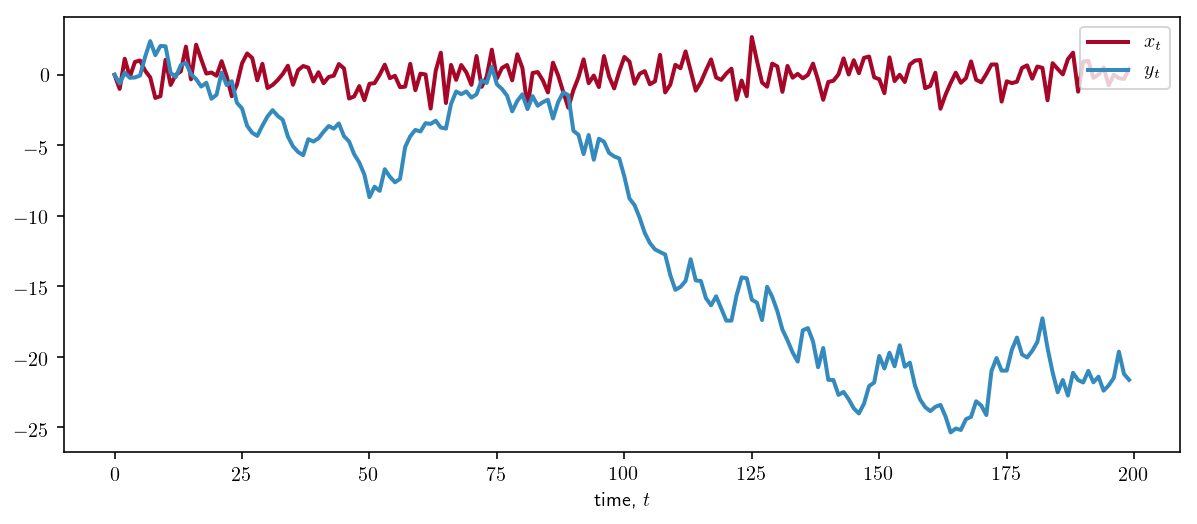

In [12]:
figsize(10, 4)
xs = np.random.normal(0, 1, 200)
xs[0] = 0
ys = np.zeros(200)
for t in range(1, 200):
    ys[t] = np.random.normal(ys[t-1], 1)

plt.plot(xs, label='$x_t$', lw=2, color=colors[0])
plt.plot(ys, label='$y_t$', lw=2, color=colors[1])
plt.legend(loc='upper right')
plt.xlabel('time, $t$')
plt.show()



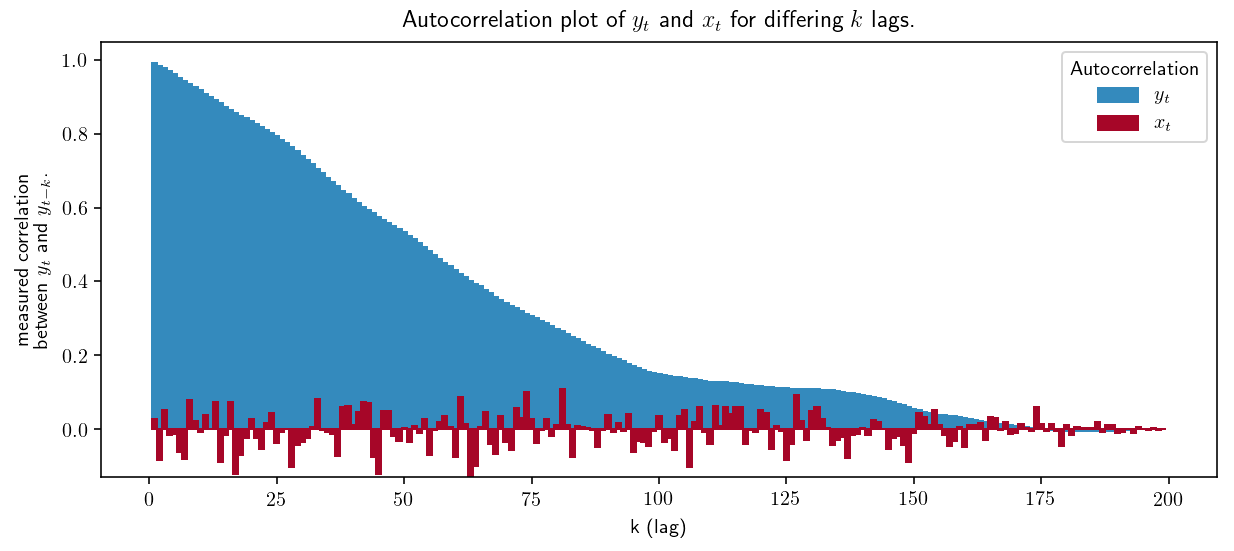

In [13]:
def autocorr(x):
    # from http://tinyurl.com/afz57c4
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

colors = ['#348ABD', '#A60628', '#7A68A6']

x = np.arange(1, 200)
plt.bar(x, autocorr(ys)[1:], width=1, label="$y_t$", color=colors[0], edgecolor=colors[0])
plt.bar(x, autocorr(xs)[1:], width=1, label="$x_t$", color=colors[1], edgecolor=colors[1])

plt.legend(title='Autocorrelation')
plt.ylabel('measured correlation \nbetween $y_t$ and $y_{t-k}$.')
plt.xlabel('k (lag)')
plt.title('Autocorrelation plot of $y_t$ and $x_t$ for differing $k$ lags.')
plt.show()

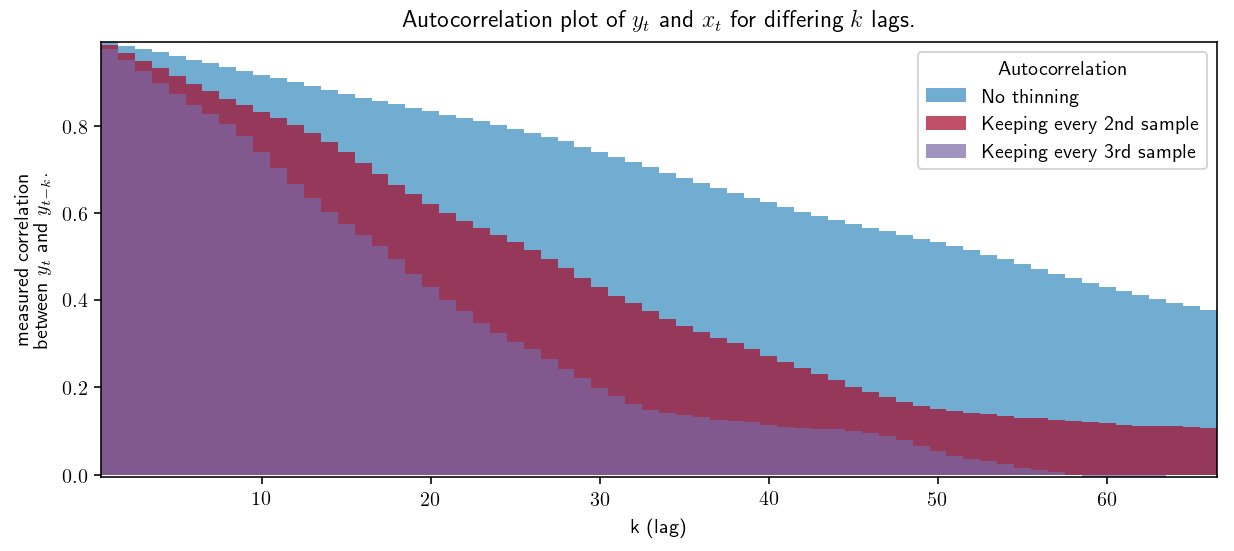

In [14]:
max_x = 200 // 3 + 1
x = np.arange(1, max_x)

plt.bar(x, autocorr(ys)[1:max_x], width=1, color=colors[0], alpha=.7, label='No thinning')
plt.bar(x, autocorr(ys[::2])[1:max_x], width=1, color=colors[1], alpha=.7, label='Keeping every 2nd sample')
plt.bar(x, autocorr(ys[::3])[1:max_x], width=1, color=colors[2], alpha=.7, label='Keeping every 3rd sample')

plt.autoscale(tight=True)
plt.legend(title='Autocorrelation')
plt.ylabel('measured correlation \nbetween $y_t$ and $y_{t-k}$.')
plt.xlabel('k (lag)')
plt.title('Autocorrelation plot of $y_t$ and $x_t$ for differing $k$ lags.')
plt.show()

In practice, thinning of more than 10 is not necessary.

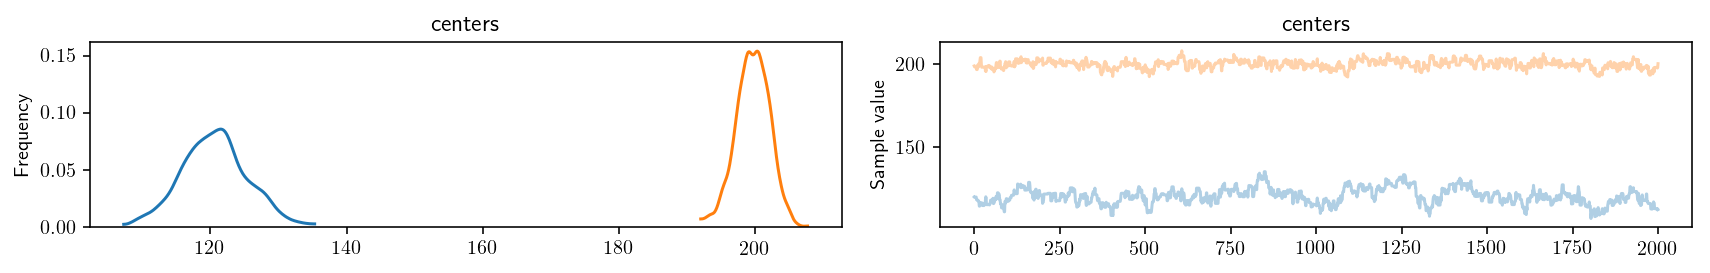

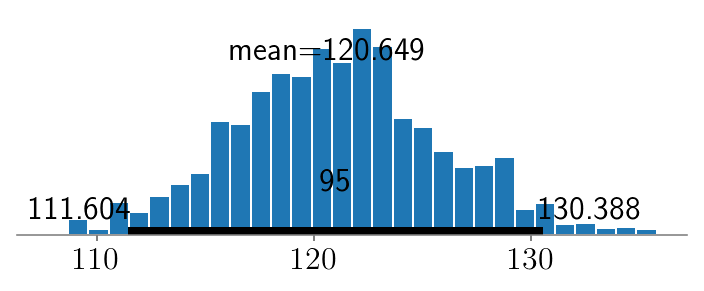

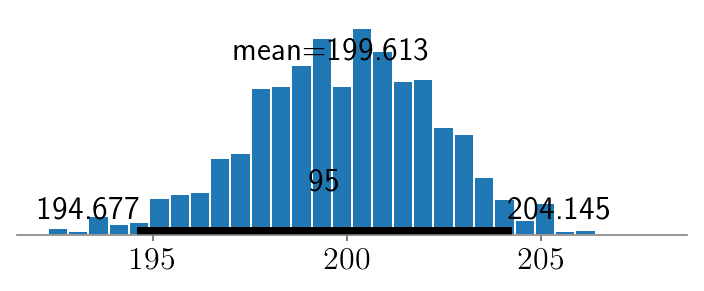

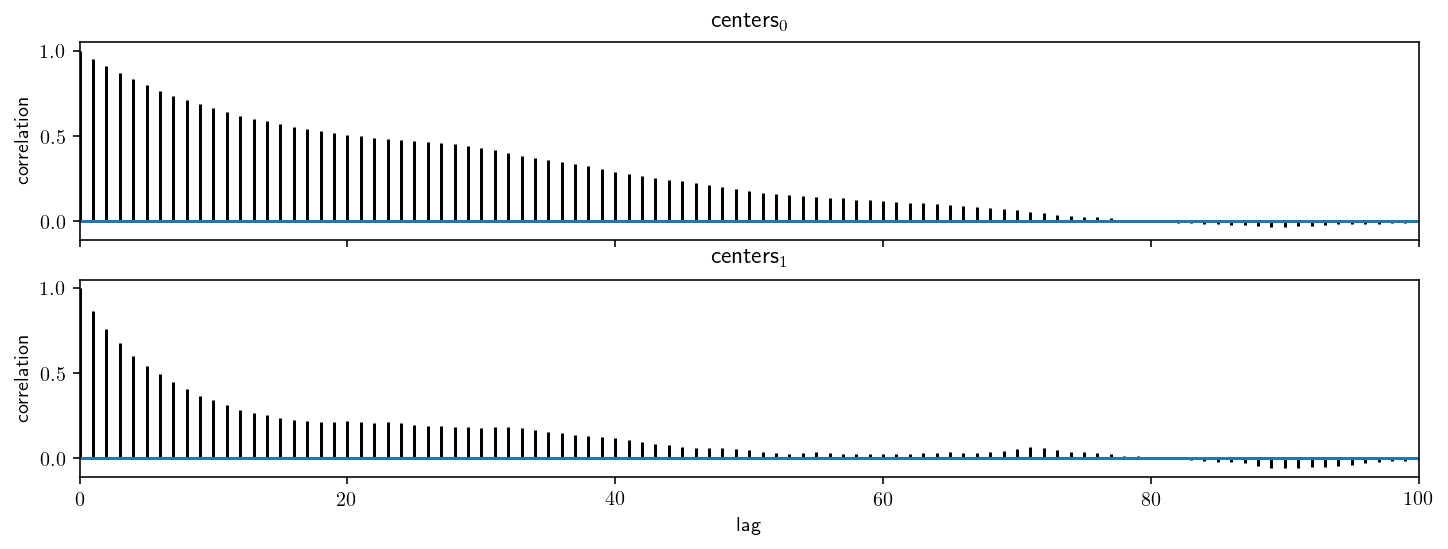

In [15]:
pm.plots.traceplot(trace, varnames=['centers'])
pm.plots.plot_posterior(trace['centers'][:, 0])
pm.plots.plot_posterior(trace['centers'][:, 1])
pm.plots.autocorrplot(trace, varnames=['centers'])
plt.show()

- 95% *credible interval*: the region marked by the horizontal back line, indicating *"95% chance the parameter of interest lies in this interval"*
- Note: should not confuse 2 terms *credible interval* (Bayesian) and *confidence interval* (Frequentist)